# Sparse Hebbian Learning: toward a quantitative measure of the quality of filters

We are interested here in learning the "optimal" components of a set of images (let's say some "natural", usual images). As there is no supervisor to guide the learning, this is called unsupervised learning. Our basic hypothesis to find the best ("optimal") components will be to assume that *a priori* the most sparse is more plausible. We will implement the derived algorithm in this set of scripts.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4, suppress=True)

## experiments

To test and control for the role of different parameters, we will have a first object (in the [shl_experiments.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_experiments.py) script) that controls a learning experiment. It contains all relevant parameters, but can also keep a trace of the history of some statistics. This is useful to compare the relative efficiency of the different solutions.


In [3]:
tag = 'coding'
homeo_methods = ['None', 'HAP', 'HEH']


record_num_batches = 2**12

seed = 42
np.random.seed(seed)

from shl_scripts.shl_experiments import SHL
shl = SHL()
data = shl.get_data(matname=tag)
indx = np.random.permutation(data.shape[0])[:record_num_batches]

list_figures = []

dico = {}
for homeo_method in homeo_methods:
    print(19*'🐶' + homeo_method + 10*'🐶')
    shl = SHL(homeo_method=homeo_method)
    dico[homeo_method] = shl.learn_dico(data=data, list_figures=list_figures, matname=tag + '_' + homeo_method)


🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶None🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶HAP🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶
🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶HEH🐶🐶🐶🐶🐶🐶🐶🐶🐶🐶


## theory



In [4]:
from scipy.stats import binom
# define the mean
rho = shl.l0_sparseness / shl.n_dictionary

# draw binomial samples
sparse_code_binary = np.random.rand(record_num_batches, shl.n_dictionary) > 1 - rho

In [5]:
print('Sum of non-zero coefficients', sparse_code_binary.sum(), '~=', shl.l0_sparseness*record_num_batches)
print('average non-zeros', np.count_nonzero(sparse_code_binary, axis=0).mean(), '~=', rho*record_num_batches)
print('activation vector', np.count_nonzero(sparse_code_binary, axis=0))

Sum of non-zero coefficients 118903 ~= 118784
average non-zeros 224.76937618147448 ~= 224.5444234404537
activation vector [225 228 225 224 223 242 236 217 255 232 229 232 242 233 219 231 224 230
 235 235 240 202 222 239 247 209 233 242 212 209 241 221 249 197 231 202
 222 216 237 222 225 250 203 198 253 233 242 234 215 227 205 234 232 217
 217 226 238 201 241 227 235 220 229 218 227 221 242 209 210 208 233 235
 224 248 225 231 198 204 223 207 236 218 239 231 249 234 232 220 218 236
 229 229 237 251 227 237 239 223 211 240 221 245 230 229 222 265 237 244
 202 216 224 227 212 260 240 219 231 251 214 212 208 214 215 229 225 208
 226 229 240 227 204 239 231 227 215 229 252 218 213 209 223 228 217 224
 231 232 216 232 227 216 259 259 190 191 237 223 223 233 209 221 217 212
 210 200 214 226 227 236 243 227 247 255 222 208 196 252 206 216 223 185
 215 209 216 242 214 211 223 232 224 238 230 230 216 222 208 211 214 228
 216 224 203 250 203 200 231 221 218 232 216 218 231 212 224 236 228 231
 2

Shape of co-occurrences (4096, 529, 529)
activation vector [[225  11  11 ...  13  14  11]
 [ 11 228  13 ...   8  12   8]
 [ 11  13 225 ...  12   9  10]
 ...
 [ 13   8  12 ... 227  22   9]
 [ 14  12   9 ...  22 210   8]
 [ 11   8  10 ...   9   8 200]]
marginal activation vector [12.7127 13.2457 12.6238 12.4915 12.6692 13.5217 13.3346 12.6049 14.482
 13.0378 13.0397 13.0057 13.7902 13.293  12.5614 13.2741 12.6333 12.8847
 13.3176 13.259  13.4594 11.7183 12.7108 13.5009 13.707  11.8015 13.3497
 13.6957 12.104  11.983  13.7769 12.5633 14.1342 11.3289 13.1172 11.5198
 12.4839 12.1815 13.4612 12.6862 12.8715 14.276  11.3667 11.2268 14.2344
 13.1626 13.7637 13.2836 11.9338 12.7807 11.6711 13.397  13.1059 12.2684
 12.1361 12.8147 13.6314 11.5198 13.8053 12.5577 13.6011 12.5009 13.0416
 12.4234 12.6975 12.6578 13.6389 11.794  11.9187 11.7278 13.1796 13.1777
 12.5728 13.8601 12.7883 13.2514 11.2363 11.7259 12.7164 11.7183 13.4594
 12.3724 13.4953 13.0397 14.0681 13.0378 12.845  12.6068 12.0397 1

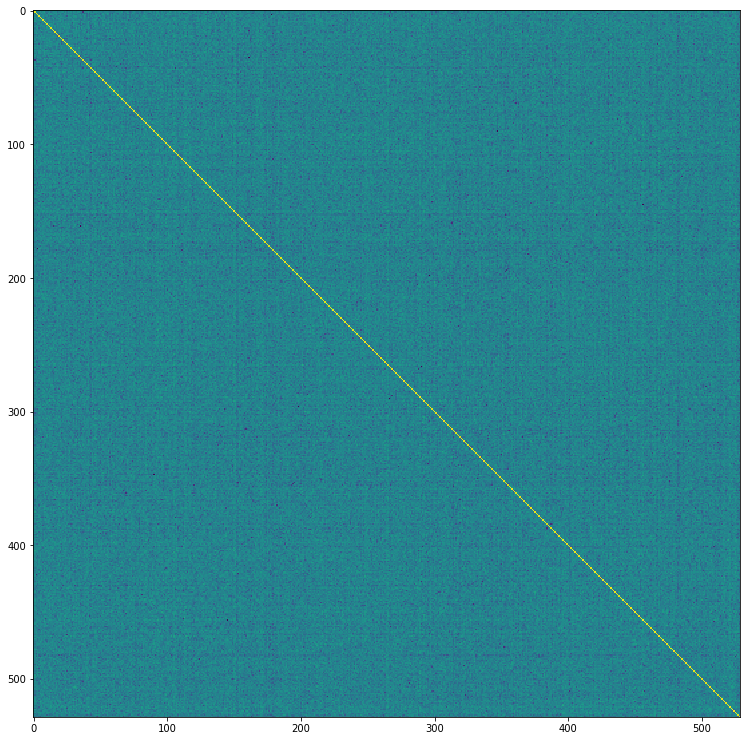

In [6]:
b_ij = (sparse_code_binary[:, np.newaxis, :]>0) * (sparse_code_binary[:, :, np.newaxis]>0)
print('Shape of co-occurrences', b_ij.shape)
print('activation vector', np.count_nonzero(b_ij, axis=0))
fig, ax= plt.subplots(figsize=(13, 13))
ax.imshow(np.log(np.count_nonzero(b_ij, axis=0)));
print('marginal activation vector', np.count_nonzero(b_ij, axis=0).mean(axis=-1))

In [ ]:
b_ij = (sparse_code_binary[:, np.newaxis, :]>0) * (sparse_code_binary[:, :, np.newaxis]>0)
P_ij = 1.*np.count_nonzero(b_ij, axis=0)
P_ij /= P_ij.sum()
P_i = 1.*np.count_nonzero(sparse_code_binary, axis=0)
P_i /= P_i.sum()
fig, ax= plt.subplots(figsize=(13, 13))
MI_ = - (P_ij * np.log( P_i[:, np.newaxis]*P_i[np.newaxis, :] / P_ij  ))
MI_[P_ij==0] = 0
MI_[(P_i[:, np.newaxis]*P_i[np.newaxis, :])==0] = 0
print('Min-Max', MI_.min(), MI_.max())
np.fill_diagonal(MI_, 0)
ax.imshow(MI_);

In [ ]:
fig, ax= plt.subplots(figsize=(13, 5))
ax.hist(MI_.ravel(), bins=200)
ax.set_yscale('log');

In [ ]:
def get_MI(sparse_code):
    b_ij = (sparse_code[:, np.newaxis, :]>0) * (sparse_code[:, :, np.newaxis]>0)
    P_ij = 1.*np.count_nonzero(b_ij, axis=0)
    P_ij /= P_ij.sum()
    P_i = 1.*np.count_nonzero(sparse_code_binary, axis=0)
    P_i /= P_i.sum()
    MI_ = - P_ij * np.log( P_i[:, np.newaxis]*P_i[np.newaxis, :] / P_ij  )
    MI_[P_ij==0] = 0
    MI_[(P_i[:, np.newaxis]*P_i[np.newaxis, :])==0] = 0
    return MI_.sum()
    

In [ ]:
for _ in range(10):
    sparse_code_binary = np.random.rand(record_num_batches, shl.n_dictionary) > 1 - rho
    MI = get_MI(sparse_code_binary)
    print ('Mutual information for random sample=', MI)

## coding

The learning itself is done via a gradient descent but is highly dependent on the coding / decoding algorithm. This belongs to a another function (in the [shl_encode.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_encode.py) script)

In [ ]:
from shl_scripts.shl_tools import print_stats

In [ ]:
homeo_methods

In [ ]:
from shl_scripts.shl_encode import sparse_encode
sparse_code = {}
for homeo_method in homeo_methods:
    print(19*'🐶' + homeo_method + 10*'🐶')
    if dico[homeo_method].P_cum is None: 
        gain = np.ones(shl.n_dictionary)
    else:
        gain = None
    sparse_code[homeo_method] = sparse_encode(data[indx, :], dico[homeo_method].dictionary, 
                                 P_cum=dico[homeo_method].P_cum, l0_sparseness = shl.l0_sparseness, C=shl.C, gain=gain)
    SD, SE = print_stats(data[indx, :], dico[homeo_method].dictionary, sparse_code[homeo_method])

## measuring the distance to independance 

In [ ]:
#fig, ax= plt.subplots(figsize=(13, 5))
for homeo_method in homeo_methods:
    print(19*'🐶' + homeo_method + 10*'🐶')
    MI = get_MI(sparse_code[homeo_method])
    print ('Mutual information for homeo_method=', homeo_method, 'is', MI)


## Version used

In [ ]:
%load_ext version_information
%version_information numpy, shl_scripts, pandas